In [1]:
import os
from dotenv import load_dotenv

load_dotenv()
TOKEN_EODHD = os.getenv('TOKEN_EODHD')
TOKEN_ORATS = os.getenv('TOKEN_ORATS')

In [2]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt

import pytz
from zoneinfo import ZoneInfo
import io
import requests
import pandas as pd

In [ ]:
from eodhd import APIClient

api = APIClient(TOKEN_EODHD)
def get_stock_data(from_est, to_est):
    """ Get intraday historical data for SPY between from_est and to_est (both datetime objects in EST timezone).
    
    Args:
        from_est (datetime): Start datetime in EST timezone.
        to_est (datetime): End datetime in EST timezone (minute-inclusive).
    
    Returns:
        pd.DataFrame: DataFrame containing intraday historical data with datetime in EST timezone.
    """
    # from_utc = (from_est + relativedelta(hours = 5)).replace(tzinfo = pytz.utc)
    # to_utc = (to_est + relativedelta(hours = 5)).replace(tzinfo = pytz.utc)
    df = api.get_intraday_historical_data(
        symbol = "SPY.US", 
        interval = "1m", 
        from_unix_time = from_est.replace(tzinfo=ZoneInfo("America/New_York")).astimezone(ZoneInfo('UTC')).timestamp(), #from_utc.timestamp(),
        to_unix_time = to_est.replace(tzinfo=ZoneInfo("America/New_York")).astimezone(ZoneInfo('UTC')).timestamp()#to_utc.timestamp()
    )
    df = pd.DataFrame(df)
    df.loc[:, "datetime"] = pd.to_datetime(df.loc[:, "datetime"]) - pd.Timedelta(hours = 5)#, unit='s').dt.tz_localize('UTC').dt.tz_convert('America/New_York')
    df = df.loc[:, ["datetime", "open", "high", "low", "close", "volume"]].set_index('datetime')
    return df

df1 = get_stock_data(from_est = datetime(2022, 6, 8, 0, 0), to_est = datetime(2022, 6, 9, 0, 0))

c:\Users\Jian\pyhome\GITHUB\options-strategy-backtest\.venv\Lib\site-packages\pandas\core\indexes\base.py:7654: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [12]:
def get_options_data(trade_minute_est):
    """ Get options data for SPY at the given trade minute in EST timezone.
    
    Args:
        trade_minute_est (datetime): Trade minute in EST timezone (seconds must be zero).
    
    Returns:
        pd.DataFrame: DataFrame containing filtered options data.
    """
    assert trade_minute_est.second == 0, "Seconds must be zero"
    trade_date_str = trade_minute_est.strftime("%Y%m%d%H%M")
    url = "https://api.orats.io/datav2/historical/one-minute/strikes/chain"

    querystring = {"token" : TOKEN_ORATS, "ticker" : "SPY", "tradeDate" : trade_date_str}
    response = requests.request("GET", url, params=querystring)
    df = pd.read_csv(io.StringIO(response.content.decode('utf-8')))
    if response.status_code == 404:
        return None
    df_out = df[
            (df.loc[:, "dte"] == 1) #&
            # ((df.loc[:, "delta"] > 0.05) | ((df.loc[:, "delta"] - 1).abs() < 0.95)) &
            # ((df.loc[:, "delta"] < 0.95) | ((df.loc[:, "delta"] - 1).abs() > 0.05)) &
            # (df.loc[:, "delta"].abs() < 0.95)
        ].eval("callDelta = delta").eval("putDelta = callDelta - 1").loc[:, [
            "strike", "stockPrice", "callDelta", "putDelta", 'callMidIv', 'putMidIv',
            'callOpenInterest', 'callVolume', 'callBidSize', 'callAskSize', 'callBidPrice', 'callAskPrice',
            'putOpenInterest', 'putVolume', 'putBidSize', 'putAskSize', 'putBidPrice', 'putAskPrice'
        ]].assign(time = trade_minute_est)
    return df_out

In [13]:
a = get_options_data(trade_minute_est = datetime(2022, 6, 8, 10, 30))

In [52]:
start = datetime(2022, 6, 8, 9, 30)
end = datetime(2022, 6, 8, 15, 0)
delta = relativedelta(minutes = 10)

dfs = list()
while start <= end:
    df = get_options_data(trade_minute_est = start)
    print(f"Options data at {start}: {len(df) if df is not None else 'No data'} rows")
    dfs.append(df)
    start += delta
df2 = pd.concat(dfs, axis=0)

Options data at 2022-06-08 09:30:00: No data rows
Options data at 2022-06-08 09:40:00: 17 rows
Options data at 2022-06-08 09:50:00: 17 rows
Options data at 2022-06-08 10:00:00: 17 rows
Options data at 2022-06-08 10:10:00: 18 rows
Options data at 2022-06-08 10:20:00: 17 rows
Options data at 2022-06-08 10:30:00: 17 rows
Options data at 2022-06-08 10:40:00: 18 rows
Options data at 2022-06-08 10:50:00: 18 rows
Options data at 2022-06-08 11:00:00: 17 rows
Options data at 2022-06-08 11:10:00: 17 rows
Options data at 2022-06-08 11:20:00: 17 rows
Options data at 2022-06-08 11:30:00: 17 rows
Options data at 2022-06-08 11:40:00: 17 rows
Options data at 2022-06-08 11:50:00: 18 rows
Options data at 2022-06-08 12:00:00: 18 rows
Options data at 2022-06-08 12:10:00: 18 rows
Options data at 2022-06-08 12:20:00: 18 rows
Options data at 2022-06-08 12:30:00: 17 rows
Options data at 2022-06-08 12:40:00: 16 rows
Options data at 2022-06-08 12:50:00: 16 rows
Options data at 2022-06-08 13:00:00: 15 rows
Optio

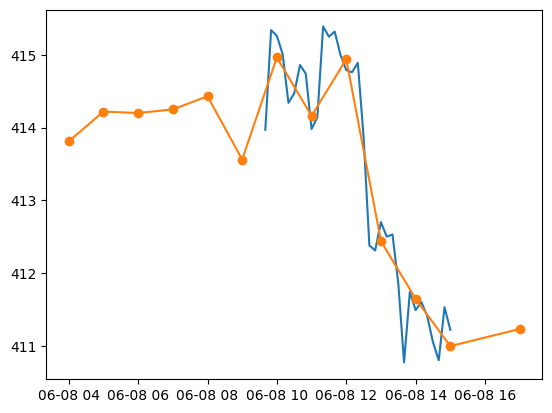

In [61]:
plt.plot(df2.loc[:, ["time", "stockPrice"]].drop_duplicates().set_index('time').iloc[:, 0])
plt.plot(df1[df1.index.minute == 0].close.shift(1), marker='o')


In [67]:
df1b = get_stock_data(from_est = datetime(2022, 1, 3, 0, 0), to_est = datetime(2022, 1, 4, 0, 0))

start = datetime(2022, 1, 3, 8, 30)
end = datetime(2022, 1, 3, 16, 0)
delta = relativedelta(minutes = 10)

dfs = list()
while start <= end:
    df = get_options_data(trade_minute_est = start)
    print(f"Options data at {start}: {len(df) if df is not None else 'No data'} rows")
    dfs.append(df)
    start += delta
df2b = pd.concat(dfs, axis=0)


Options data at 2022-01-03 08:30:00: No data rows
Options data at 2022-01-03 08:40:00: No data rows
Options data at 2022-01-03 08:50:00: No data rows
Options data at 2022-01-03 09:00:00: No data rows
Options data at 2022-01-03 09:10:00: No data rows
Options data at 2022-01-03 09:20:00: No data rows
Options data at 2022-01-03 09:30:00: No data rows
Options data at 2022-01-03 09:40:00: 3 rows
Options data at 2022-01-03 09:50:00: 8 rows
Options data at 2022-01-03 10:00:00: 10 rows
Options data at 2022-01-03 10:10:00: 11 rows
Options data at 2022-01-03 10:20:00: 10 rows
Options data at 2022-01-03 10:30:00: 8 rows
Options data at 2022-01-03 10:40:00: 9 rows
Options data at 2022-01-03 10:50:00: 8 rows
Options data at 2022-01-03 11:00:00: 9 rows
Options data at 2022-01-03 11:10:00: 7 rows
Options data at 2022-01-03 11:20:00: 7 rows
Options data at 2022-01-03 11:30:00: 7 rows
Options data at 2022-01-03 11:40:00: 8 rows
Options data at 2022-01-03 11:50:00: 8 rows
Options data at 2022-01-03 12:0

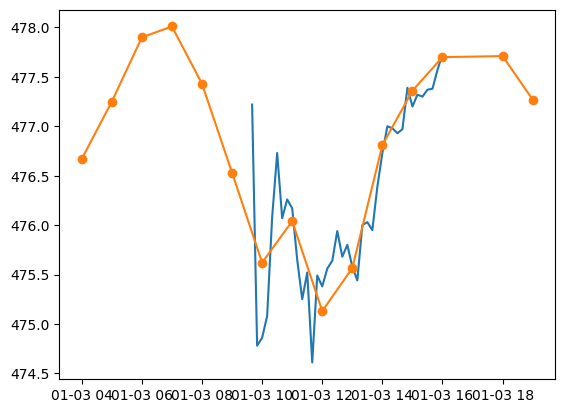

In [70]:
plt.plot(df2b.loc[:, ["time", "stockPrice"]].drop_duplicates().set_index('time').iloc[:, 0])
plt.plot(df1b[df1b.index.minute == 0].close, marker='o')
